
# Linear Spatial Autocorrelation Model



The two methodologies under study (i.e. Meta-analysis and  distributed networks) share the assumption that the observations are independent between each other. In other words, if two plots (say p1 and p2 ) are from different studies, the covariance between p1 and p2 is zero. The assumption is reasonable because of the character of both methodologies. Data derived from meta-analysis and distributed networks is composed of experiments measured in different environmental conditions and geographical locations; using an assortment of experimental techniques and sample designs. It is therefore reasonable to expect that the residuals derived from a linear statistical model will be explained by a non structured error (e.g. $epsilon \sim N(0,\sigma^2)).

Data Used and computational challenges

The dataset used as reference was the FIA dataset. It comprises more than 36k plot records. Each with a different spatial coordinate. Analysing the data for spatial effects require to manage a 36k x 36k matrix and the parameter optimization through GLS requires to calculate  the inverse as well. 


Model specification
The spatial model proposed follows a classical geostatistical approach. In other words, an empirical variogram was used to estimate a {\em valid} analytical model (Webster and Oliver, 2001). In accordance with the model simulations, the spatial model  is as follows:

$$log Biomass = log(Spp Richness) + S_x + \epsilon$$

Where: $$E(log(biomass)) = \beta_0 log(Spp Richness)$  and $Var(y) = [\tau^2 \rho(|x,x’|) + \sigma^2] $$ 


$\tau$ is a variance  parameter of the gaussian isotropic and stationary process S_x with spatial autocorrelation distance function $\rho$ given by:

$$\rho (h)=(s-n)\left(1-\exp \left(-{\frac  {h^{2}}{r^{2}}}\right)\right)+n1_{{(0,\infty )}}(h)$$

Where $h$ is the distance $|x,x’|$ ,  $s$, $n$ and $r$ are the parameters for sill, nugget and range.




Exploratory analysis

To begin with, a linear model using OLS was fitted using a log-log transformation of Biomass and Species Richness as response variable and covariate (respectively). I.e.

$ (log(Biomass) | S) = \beta log(Spp Richness) + \epsilon $

A histogram of the residuals shows a symmetric distribution (see figure below). 


The residuals show no significant spatial trend across latitude or longitude (see figures 2bis and 3bis). We decided to follow the principle of model parsimony by not including the spatial coordinates as covariates (fixed effect).




Empirical Variogram and model fit
The residuals however, show  variance dependent on the distance (autocorrelation). An empirical variogram was calculated to account for this effect (see figure below). The variogram was calculated using 50 lag distances of 13.5 km each (derived from dividing the data’s distance matrix range by 50). A Monte Carlo envelope method (blue region) at 0.25 and 0.975 quantiles was calculated to designate the region under the null hypothesis, i.e. with no spatial autocorrelation (Diggle and Ribeiro, 2003).

The resulting variogram (orange dots) show a typical spatial autocorrelation pattern, distinct from complete randomness and with an increasing variance as a function of distance. Using this pattern we fitted a gaussian model using non-linear least squares method implemented in Scipy.optimize.curve_fit (Jones et.al., 2017). The results obtained were: Sill 0.341, Range 50318.763, Nugget 0.33 . The resulting function is overlapped in green.


 

Conclusion

The model: $log(Biomass) = \beta log(Spp_richness) + \epsilon$ presents non-explicative random effects with spatial autocorrelation. The variogram of its residuals shows a typical pattern for distance dependent heteroscedasticity.  In other words, the correlation of distinct data points depends on the distance i.e. ($Cov(p_1,p_2) = \sigma^2 \rho(|p_1 - p_2|^2)$) where $\rho$ is a spatial auto-correlation function (derived from the empirical variogram under a gaussian model assumption). 

The observations reject the assumptions of the linear model estimator obtained by OLS, those on independence and identically distributed errors. The Generalised Least Square (GLS) estimator would be a better approach for obtaining the linear parameters but more importantly a more reliable variance and consequently  more reliable confidence interval.

Recommendations and future work
The whole dataset unveiled a spatial structure that needs to be accounted for in both studies; distributed plots and independent studies. The GLS estimator is a more robust method for optimising the linear models. The covariance matrix (used in meta-analysis) can be extended to include a spatial effect and derive better estimators and their confidence interval. 
 


In [5]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
## Use the ggplot style
plt.style.use('ggplot')

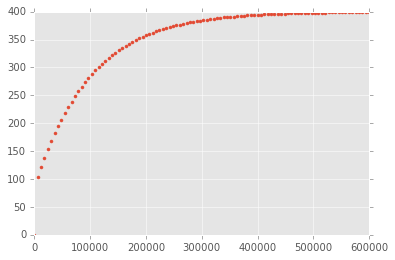

In [331]:
## check the matern
import scipy.special as special
#def MaternVariogram(h,range_a,nugget=40,sill=100,kappa=0.5):
def MaternVariogram(h,sill=1,range_a=100,nugget=40,kappa=0.5):    
    """
    The Matern Variogram of order $\kappa$.
   
    $$ \gamma(h) = nugget + (sill (1 - (\farc{1}{2^{\kappa -1}} \Gamma(\kappa) (\frac{h}{r})^{\kappa} K_\kappa \Big(\frac{h}{r}\Big)$$
    
    Let:
         a = $$ 
        b = $$
        K_v = Modified Bessel function of the second kind of real order v
    """
    
    #a = np.power(2, 1 - kappa) / special.gamma(kappa)
    #b = (np.sqrt(2 * kappa) / range_a) * h
    a = 1 / np.power(2,kappa - 1 ) * special.gamma(kappa)
    
    b = (h / float(range_a))
    K_v = special.kv(kappa,b)
    
    #kh = sigma * a * np.power(b,kappa) * K_v
    #kh = (sill - nugget) * ( 1 - (a * np.power(b,kappa) * K_v))
    kh = nugget + (sill * ( 1 - (a * np.power(b,kappa) * K_v)))

    kh = np.nan_to_num(kh)

    return kh
    

cc = MaternVariogram(hx,range_a=100000,sill=100,nugget=300,kappa=0.5)
plt.plot(hx,cc,'.')

$$ \gamma(h) = nugget + (sill (1 - (\frac{1}{2^{\kappa -1}} \Gamma(\kappa) (\frac{h}{r})^{\kappa} K_\kappa \Big(\frac{h}{r}\Big)$$


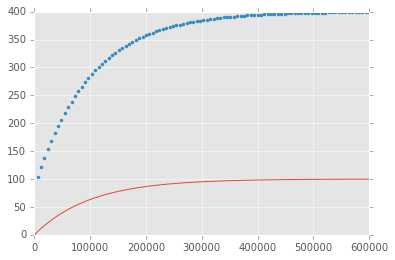

In [332]:
from external_plugins.spystats import tools
gx = tools.exponentialVariogram(hx,sill=100,nugget=0,range_a=100000)
plt.plot(hx,gx)
plt.plot(hx,cc,'.')

In [333]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
    else:
        Ih = 1.0 if h >= 0 else 0.0
    #Ih = 1.0 if h >= 0 else 0.0    
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget*Ih
    return g_h
## Fitting model.
### Optimizing the empirical values
def theoreticalVariogram(model_function,sill,range_a,nugget,kappa=0):
    if kappa == 0:
        return lambda x : model_function(x,sill,range_a,nugget)
    else: 
        return lambda x : model_function(x,sill,range_a,nugget,kappa)


### Relating the Semivariogram with the correlation function
The variogram of a spatial stochastic process $S(x)$ is the function:
$$ V(x,x') = \frac{1}{2} Var \{ S(x) - S(x')  \} $$

Note that :
$$V(x,x') = \frac{1}{2} \{ Var(S(x)) + Var(S(x') - 2Cov(S(x),S(x')) \} $$

For the stationary case: 
$$ 2 V(u) = 2\sigma^2 (1 - \rho(u)) $$
So:
$$ \rho(u) = 1 - \frac{V(u)}{\sigma^2} $$


In [334]:
from external_plugins.spystats import tools
%run ../testvariogram.py

In [335]:
## Remove duplications
withoutrep = new_data.drop_duplicates(subset=['newLon','newLat'])
print(new_data).shape
print(withoutrep).shape
new_data = withoutrep


(36845, 48)
(36844, 48)


new_data.residuals2.hist()
plt.title('Residuals of $log(Biomass) \sim log(Spp_{rich})$')
##------------------

plt.scatter(new_data.newLon,new_data.residuals2)
plt.xlabel('Longitude (meters)')
plt.ylabel('Residuals: $log(Biomass) - \hat{Y}$')

##-------------------
plt.scatter(new_data.newLat,new_data.residuals2)
plt.xlabel('Latitude (meters)')
plt.ylabel('$Residuals: log(Biomass) - \hat{Y}$')


## Read the data

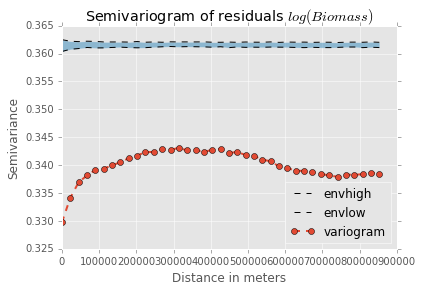

In [357]:
### Read the data first
#hx = np.linspace(0,400000,100)
#spmodel = theoreticalVariogram(gaussianVariogram,sill,range_a,nugget)
#nt = 30 # num iterations
thrs_dist = 100000
empirical_semivariance_log_log = "../HEC_runs/results/logbiomas_logsppn_res.csv"
filename = "../HEC_runs/results/low_q/data_envelope.csv"

#### here put the hec calculated 
envelope_data = pd.read_csv(filename)
emp_var_log_log = pd.read_csv(empirical_semivariance_log_log)
gvg = tools.Variogram(new_data,'logBiomass',using_distance_threshold=thrs_dist)
gvg.envelope = emp_var_log_log
gvg.empirical = emp_var_log_log.variogram
gvg.lags = emp_var_log_log.lags
emp_var_log_log = emp_var_log_log.dropna()
vdata = gvg.envelope.dropna()
gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.title("Semivariogram of residuals $log(Biomass) ~ log(SppR)$")

## The best fitted values were:
(Processed by chunks see: http://localhost:8888/notebooks/external_plugins/spystats/notebooks/variogram_envelope_by_chunks.ipynb )

* Sill 0.34122564947
* Range 50318.763452
* Nugget 0.329687351696


In [337]:
sill = 0.34122564947
range_a = 50318.763452
nugget = 0.329687351696

In [338]:
import matplotlib.pylab as plt
hx = np.linspace(0,600000,100)
from scipy.optimize import curve_fit
s = 0.345
r = 50000.0
nugget = 0.33
kappa = 0.5
init_vals = [s,r,nugget] # for [amp, cen, wid]
init_matern = [s,r,nugget,kappa]
#bg, covar_gaussian = curve_fit(gaussianVariogram, xdata=emp_var_log_log.lags.values, ydata=emp_var_log_log.variogram.values, p0=init_vals)
bg, covar_gaussian = curve_fit(MaternVariogram, xdata=emp_var_log_log.lags.values, ydata=emp_var_log_log.variogram.values, p0=init_matern)
#MaternVariogram(h,range_a,nugget=40,sill=100,kappa=0.5)
#vdata = gvg.envelope.dropna()
## The best parameters asre:
#gau_var = tools.gaussianVariogram(hx,bg[0],bg[1],bg[2])
gau_var = MaternVariogram(hx,bg[0],bg[1],bg[2],bg[3])


sill = bg[0]
range_a = bg[1]
nugget = bg[2]
kappa = bg[3]
spmodel = theoreticalVariogram(MaternVariogram,sill,range_a,nugget,kappa)
#spmodel = theoreticalVariogram(gaussianVariogram,sill,range_a,nugget)
#MaternVariogram(0,sill,range_a,nugget,kappa)



In [339]:
results = "Sill %s , range_a %s , nugget %s, kappa %s"%(sill,range_a,nugget,kappa)
print(results)

Sill 0.00921699922064 , range_a 23280.6168393 , nugget 0.331058893807, kappa 1.72403095525


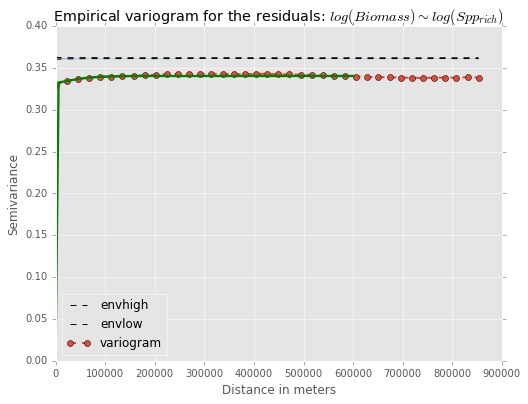

In [340]:
#n_points = pd.DataFrame(map(lambda v : v.n_points,variograms2))
#points = n_points.transpose()
#ejem2 = pd.DataFrame(variogram2.values * points.values)
# Chunks (variograms) columns
# lag rows
#vempchunk2 = ejem2.sum(axis=1) / points.sum(axis=1)
#plt.plot(lags,vempchunk2,'--',color='blue',lw=2.0)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
thrs_dist = 1000000


gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.title("Empirical variogram for the residuals: $log(Biomass) \sim log(Spp_{rich}) $ ")
plt.plot(hx,spmodel(hx),color='green',lw=2.3)

## Todo: Fit Matern

In [341]:
X = np.linspace(0,600000,50)
tvar = spmodel(X)
correlation_h = lambda h :  1 - (spmodel(h))

In [342]:
spmodel(0)

0.0

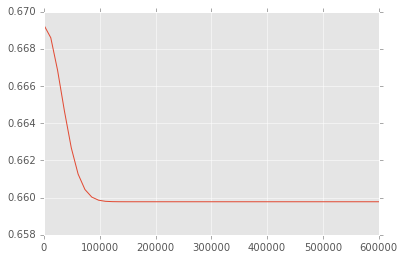

In [343]:
plt.plot(X,correlation)

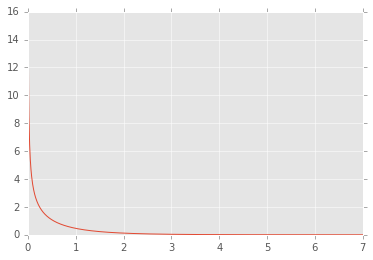

In [344]:
plt.plot(np.linspace(0,7,1000),special.kv(0.5,np.linspace(0,7,1000)))


## GLS estimation.
It's not possible to do it all in the server or this computer because it requires massive computational capacity.

I'll do it with a geographical section or sample.
Taken from:
http://localhost:8888/notebooks/external_plugins/spystats/notebooks/Analysis_spatial_autocorrelation_with_empirical_variogram_using_GLS.ipynb

Re fit the $\beta$ 

Oke, first calculate the distances


In [345]:
def randomSelection(data,k):
    n = len(data)
    idxs = np.random.choice(n,k,replace=True)
    random_sample = data.iloc[idxs]
    return random_sample
#################
#n = len(new_data)
#p = 3000 # The amount of samples taken (let's do it without replacement)

def systSelection(data,k):
    n = len(data)
    idxs = range(0,n,k)
    systematic_sample = data.iloc[idxs]
    return systematic_sample
##################
n = len(new_data)
k = 10 # The k-th element to take as a sample

def subselectDataFrameByCoordinates(dataframe,namecolumnx,namecolumny,minx,maxx,miny,maxy):
    """
    Returns a subselection by coordinates using the dataframe/
    """
    minx = float(minx)
    maxx = float(maxx)
    miny = float(miny)
    maxy = float(maxy)
    section = dataframe[lambda x:  (x[namecolumnx] > minx) & (x[namecolumnx] < maxx) & (x[namecolumny] > miny) & (x[namecolumny] < maxy) ]
    return section


In [346]:
sample = systSelection(new_data,10)
sample = randomSelection(new_data,10)
minx = -85
maxx = -80
miny = 30
maxy = 35

section = subselectDataFrameByCoordinates(new_data,'LON','LAT',minx,maxx,miny,maxy)

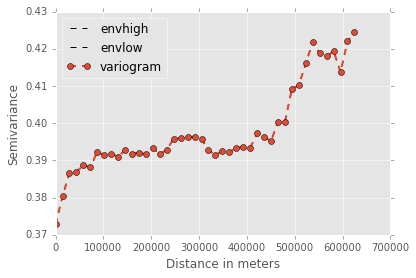

In [347]:
vsamp = tools.Variogram(section,'logBiomass')
import statsmodels.regression.linear_model as lm
Mdist = vsamp.distance_coordinates.flatten()
vsamp.plot(num_iterations=1)


In [348]:
%time vars = np.array(correlation_h(Mdist))
MMdist = Mdist.reshape(len(section),len(section))
CovMat = vars.reshape(len(section),len(section))
X = section.logSppN.values
Y = section.logBiomass.values

CPU times: user 7.71 s, sys: 270 ms, total: 7.98 s
Wall time: 7.98 s


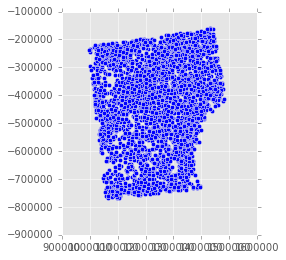

In [349]:
section.plot()

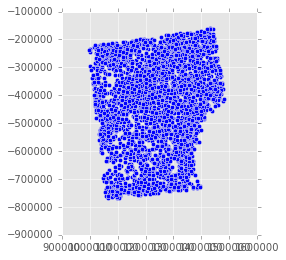

In [350]:
tt = section.geometry
tt.plot()

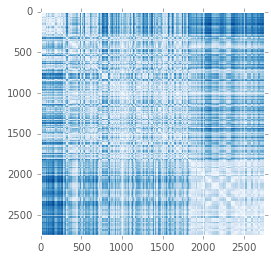

In [351]:
plt.imshow(MMdist,interpolation='None',cmap=plt.cm.Blues)

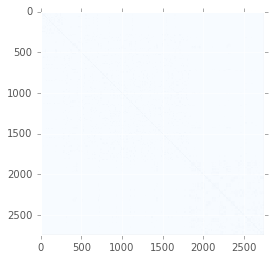

In [352]:
plt.imshow(CovMat,interpolation='None',cmap=plt.cm.Blues)

In [353]:
%time results_gls = lm.GLS(Y,X,sigma=CovMat)
#tt = np.linalg.cholesky(CovMat)
#np.linalg.eigvals(CovMat)
#CovMat.flatten()
#MMdist.flatten()
#lm.GLS?


CPU times: user 38.6 s, sys: 810 ms, total: 39.4 s
Wall time: 20.4 s


In [354]:
modelillo = results_gls.fit()

In [355]:
modelillo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.174
Model:                            GLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     578.9
Date:                Wed, 06 Dec 2017   Prob (F-statistic):          3.22e-116
Time:                        00:21:58   Log-Likelihood:                -2717.4
No. Observations:                2744   AIC:                             5437.
Df Residuals:                    2743   BIC:                             5443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4590      0.019     24.060      0.000         0.422     0.496
==============================================================================
Omnibus:                      172.000   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.715
Skew:                          -0.410   Prob(JB):                     8.60e-81
Kurtosis:                       4.598   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
## Experimental do not run in interactive mode
##But the data is massive and it consumes all my RAM (32 GB) I need to  do something clever.
covar = []
for i in range(len(Mdist)):
    x = Mdist.pop(i)
    g = gaussianVariogram(x,bg[0],bg[1],bg[2])
    covar.append(g)